# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from geopy.geocoders import Nominatim

from IPython.core.display    import HTML
from IPython.display         import Image

## Helper Functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

# Define the function to evaluate the models
def weighted_mean_absolute_error(df, y, yhat):
    weights = df.is_holiday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-yhat))/(np.sum(weights)), 2)

def ml_error( df,model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    WMAE = weighted_mean_absolute_error(df, y, yhat)
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'RMSE': rmse,
                          'WMAE': WMAE}, index=[0])

# time-series cross validation implementation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    WMAE_list = []
     
    for k in reversed( range( 1, kfold+1 ) ): #k-fold implementation
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( weeks=k*22) #primeira semanada da venda realizada
        end_date_validation = x_training['date'].max() - datetime.timedelta( weeks=(k-1)*22) #ultima semana

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'weekly_sales'], axis=1 ) 
        ytraining = training['weekly_sales']

        # validation
        xvalidation = validation.drop( ['date', 'weekly_sales'], axis=1 )
        yvalidation = validation['weekly_sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( xvalidation, model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        rmse_list.append( m_result['RMSE'] )
        WMAE_list.append( m_result['WMAE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':  np.round( np.mean( mae_list ), 2 ).astype( str )  + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ),
                          'WMAE CV': np.round( np.mean( WMAE_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( WMAE_list ), 2 ).astype( str )}, i)

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# LOADING DATA

In [ ]:
#project home path for importing files
home_path = 'C:/Users/af_na/repos/hackday/'

#loading datasets available for this project
df_treino              = pd.read_csv(home_path + 'data/treino.csv', low_memory = False)
df_teste               = pd.read_csv(home_path + 'data/teste.csv', low_memory = False)
df_sample_submission   = pd.read_csv(home_path + 'data/sample_submission.csv', low_memory = False)

In [ ]:
df_treino.describe().round(2)

,num_fotos,ano_de_fabricacao,ano_modelo,odometro,num_portas,attr_veiculo_alienado,preco
count,39209.00,39446.00,39446.00,39446.00,39446.00,0.0,39446.00
mean,10.32,2016.75,2017.81,58382.24,3.94,NaN,133385.87
std,3.48,4.08,2.68,32542.79,0.34,NaN,82384.97
min,8.00,1985.00,1997.00,100.00,2.00,NaN,7258.16
25%,8.00,2015.00,2016.00,31235.25,4.00,NaN,76774.32
50%,8.00,2018.00,2018.00,57244.50,4.00,NaN,114307.97
75%,14.00,2019.00,2020.00,81925.75,4.00,NaN,163987.00
max,21.00,2022.00,2023.00,390065.00,4.00,NaN,1359812.89


# TRATANDO VARIAVEIS NULAS

In [ ]:
## Dropando a coluna que não tem informações
df_treino.drop(['attr_veiculo_alienado', 'elegivel_revisao'], axis=1, inplace= True)
# Limpeza de NAN's

## Veiculo Aceita Troca
df_treino['attr_veiculo_aceita_troca'] = df_treino['attr_veiculo_aceita_troca'].fillna('Não')

## Único Dono
df_treino['attr_veiculo_único_dono'] = df_treino['attr_veiculo_único_dono'].fillna('Não')

## Todas as revisões feitas pela concessionária
df_treino['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df_treino['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].fillna('Não')

## IPVA Pago
df_treino['attr_veiculo_ipva_pago'] = df_treino['attr_veiculo_ipva_pago'].fillna('Não')

## Veículo Licenciado
df_treino['attr_veiculo_licenciado'] = df_treino['attr_veiculo_licenciado'].fillna('Não')

## Garantia de Fábrica
df_treino['attr_veiculo_garantia_de_fábrica'] = df_treino['attr_veiculo_garantia_de_fábrica'].fillna('Não')

## Revisões feitas pela agenda do carro
df_treino['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df_treino['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].fillna('Não')

## Número de fotos
df_treino['num_fotos'] = df_treino['num_fotos'].fillna(0)

In [ ]:
df_treino.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro', 'preco',
       'potencia'],
      dtype='object')

In [ ]:
## Dropando a coluna que não tem informações
df_teste.drop(['attr_veiculo_alienado', 'elegivel_revisao'], axis=1, inplace= True)
# Limpeza de NAN's

## Veiculo Aceita Troca
df_teste['attr_veiculo_aceita_troca'] = df_teste['attr_veiculo_aceita_troca'].fillna('Não')

## Único Dono
df_teste['attr_veiculo_único_dono'] = df_teste['attr_veiculo_único_dono'].fillna('Não')

## Todas as revisões feitas pela concessionária
df_teste['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df_teste['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].fillna('Não')

## IPVA Pago
df_teste['attr_veiculo_ipva_pago'] = df_teste['attr_veiculo_ipva_pago'].fillna('Não')

## Veículo Licenciado
df_teste['attr_veiculo_licenciado'] = df_teste['attr_veiculo_licenciado'].fillna('Não')

## Garantia de Fábrica
df_teste['attr_veiculo_garantia_de_fábrica'] = df_teste['attr_veiculo_garantia_de_fábrica'].fillna('Não')

## Revisões feitas pela agenda do carro
df_teste['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df_teste['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].fillna('Não')

## Número de fotos
df_teste['num_fotos'] = df_teste['num_fotos'].fillna(0)

In [ ]:
df_teste.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'potencia'],
      dtype='object')

# Criando variavel potencia para teste e treino

In [ ]:
df_teste['potencia'] = df_teste['versao'].str.split(' ').str[0]
df_teste['potencia'].unique()

array(['1.8', '1.0', '2.0', '1.6', '1.5', '2.8', '2.2', '6.2', '3.2',
       '2.7', '1.4', '3.3', '1.3', '6.7', '3.0', '3.8', '3.5', '2.5',
       '3.6', 'B12P', '4.0', '3.7', '2.4', '2.3', 'P8', '4.6', '5.5',
       '1.2', '5.0', '5.7', '4.4', '2.1', '4S', '1.7', 'EV', '4.8', '2.9',
       '4.2', '90', '1.9', 'ELÉTRICO', '3.9', '0.6', 'Z.E.', '1.8S',
       '4.3', '4.5', '3.4', 'REX', 'TURBO', '4.7', 'BEV', '4.9', '4.1',
       '5.2', '1.1', '5.9'], dtype=object)

In [ ]:
df_teste['potencia'] = df_teste['potencia'].apply ( lambda x:    'ELETRICO' if x == 'B12P' else
                                                                 'ELETRICO' if x == '4S' else
                                                                 'ELETRICO' if x == 'EV' else
                                                                 'ELETRICO' if x == 'BEV' else
                                                                 'ELETRICO' if x == 'ELÉTRICO' else
                                                                 'ELETRICO' if x == 'Z.E.' else
                                                                 'ELETRICO' if x == 'TURBO' else
                                                                 '1.8'      if x == '1.8S' else
                                                                 'ELETRICO' if x == 'REX' else
                                                                 'ELETRICO' if x == '90' else
                                                                 'ELETRICO' if x == 'P8' else x )

In [ ]:
df_teste['potencia'].unique()

array(['1.8', '1.0', '2.0', '1.6', '1.5', '2.8', '2.2', '6.2', '3.2',
       '2.7', '1.4', '3.3', '1.3', '6.7', '3.0', '3.8', '3.5', '2.5',
       '3.6', 'ELETRICO', '4.0', '3.7', '2.4', '2.3', '4.6', '5.5', '1.2',
       '5.0', '5.7', '4.4', '2.1', '1.7', '4.8', '2.9', '4.2', '1.9',
       '3.9', '0.6', '4.3', '4.5', '3.4', '4.7', '4.9', '4.1', '5.2',
       '1.1', '5.9'], dtype=object)

In [ ]:
df_treino['potencia'] = df_treino['versao'].str.split(' ').str[0]
df_treino['potencia'].unique()

array(['2.0', '1.8', '1.0', '1.6', '1.4', '1.3', '3.2', '1.5', '2.2',
       '3.3', '2.8', '3.0', '2.7', '5.0', '6.7', '4.6', '2.3', '2.5',
       '2.4', '6.2', '2.9', 'B12P', '4.4', '3.6', '3.5', '4.0', '2.1',
       '3.8', '1.2', '4.8', '3.9', '4.7', '4.2', '4.3', '5.5', '5.2',
       '1.7', '4S', 'EV', '4.5', '4.1', '3.7', '5.7', '0.6', 'BEV', '90',
       '1.1', 'ELÉTRICO', '5.9', '4.9', 'TURBO', 'Z.E.', '6.3', '1.9',
       'P8'], dtype=object)

df_treino.loc[df_treino['versao_1'] == 'BEV', ['marca', 'ano_de_fabricacao', 'tipo','ano_modelo', 'modelo', 'versao']].head()

In [ ]:
df_treino['potencia'] = df_treino['potencia'].apply ( lambda x:  'ELETRICO' if x == 'B12P' else
                                                                 'ELETRICO' if x == '4S' else
                                                                 'ELETRICO' if x == 'EV' else
                                                                 'ELETRICO' if x == 'BEV' else
                                                                 'ELETRICO' if x == 'ELÉTRICO' else
                                                                 'ELETRICO' if x == 'Z.E.' else
                                                                 'ELETRICO' if x == 'TURBO' else
                                                                 'ELETRICO' if x == '90' else
                                                                 'ELETRICO' if x == 'P8' else x )

In [ ]:

df_treino['potencia'].unique()

array(['2.0', '1.8', '1.0', '1.6', '1.4', '1.3', '3.2', '1.5', '2.2',
       '3.3', '2.8', '3.0', '2.7', '5.0', '6.7', '4.6', '2.3', '2.5',
       '2.4', '6.2', '2.9', 'ELETRICO', '4.4', '3.6', '3.5', '4.0', '2.1',
       '3.8', '1.2', '4.8', '3.9', '4.7', '4.2', '4.3', '5.5', '5.2',
       '1.7', '4.5', '4.1', '3.7', '5.7', '0.6', '1.1', '5.9', '4.9',
       '6.3', '1.9'], dtype=object)

In [ ]:
df_treino['versao'].unique()

array(['2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIESEL 4P AUTOMÁTICO',
       '2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO',
       '1.8 LT 16V FLEX 4P AUTOMÁTICO', ...,
       '3.0 XL 4X4 CS TURBO ELECTRONIC DIESEL 2P MANUAL',
       '2.0 16V TWINPOWER GASOLINA S 4P STEPTRONIC',
       '1.0 EX 12V FLEX 4P MANUAL'], dtype=object)

# Criando variavel combustivel

In [ ]:
df_treino['combustivel'] = df_treino['versao'].apply ( lambda x: 'DIESEL'    if re.search('DIESEL', x) else
                                                                 'FLEX'      if re.search('FLEX', x) else
                                                                 'GASOLINA'  if re.search('GASOLINA', x) else 
                                                                 'HIBRIDO'   if re.search('HYBRID', x) else
                                                                 'HIBRIDO'   if re.search('HÍBRIDO', x) else
                                                                 'ELÉTRICO'  if re.search('ELÉTRICO', x) else
                                                                 'ELECTRIC'  if re.search('ELÉTRICO', x) else
                                                                 'ÁLCOOL'    if re.search('ÁLCOOL', x) else
                                                                 'GASOLINA'  if re.search('GAS', x) else
                                                                 'ELECTRIC'  if re.search('ELÉTRICO', x) else
                                                                 'GASOLINA'  if re.search('4.0 SPORTBACK V8 TWINTURBO MHEV TIPTRONIC', x) else
                                                                 'GASOLINA'  if re.search('200 TSI HIGHLINE AUTOMÁTICO', x) else
                                                                 'FLEX'      if re.search('1.0 200 TSI COMFORTLINE AUTOMÁTICO', x) else
                                                                 'FLEX'      if re.search('1.4 250 TSI GTS AUTOMÁTICO', x) else
                                                                 'GASOLINA'  if re.search('3.0 V6 SUPERCHARGED R-SPORT AWD 4P AUTOMÁTICO', x) else
                                                                 'GASOLINA'  if re.search('1.4 MPI 8V TETRAFUEL 4P MANUAL', x) else 
                                                                 'GASOLINA'  if re.search('2.0 16V INGENIUM PRESTIGE AWD 4P AUTOMÁTICO', x) else 
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE MOMENTUM GEARTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE MOMENTUM GEARTRONIC', x) else
                                                                 'GASOLINA'  if re.search('2.0 16V INGENIUM R-SPORT AWD 4P AUTOMÁTICO', x) else
                                                                 'HIBRIDO'   if re.search('2.0 T8 RECHARGE INSCRIPTION EXPRESSION AWD GEA', x) else
                                                                 'GASOLINA'  if re.search('4.4 V8 TWIN POWER M XDRIVE STEPTRONIC', x) else
                                                                 'FLEX'      if re.search('1.0 200 TSI SENSE AUTOMÁTICO', x) else
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE INSCRIPTION GEARTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('2.0 T8 RECHARGE INSCRIPTION AWD GEARTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('2.0 T8 RECHARGE R-DESIGN AWD GEARTRONIC', x) else
                                                                 'GASOLINA'  if re.search('5.0 V8 SUPERCHARGED SVR AWD 4P AUTOMÁTICO', x) else
                                                                 'HIBRIDO'   if re.search('P8 RECHARGE ELECTRIC BEV PURE AWD', x) else
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE R-DESIGN GEARTRONIC', x) else'NA'                                    
                                                                 )

In [ ]:
df_treino['combustivel'].unique()

array(['DIESEL', 'FLEX', 'GASOLINA', 'HIBRIDO', 'ELÉTRICO', 'ÁLCOOL'],
      dtype=object)

In [ ]:
df_treino.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro', 'preco',
       'potencia', 'combustivel'],
      dtype='object')

In [ ]:
df_teste['combustivel'] = df_teste['versao'].apply ( lambda x: 'DIESEL'    if re.search('DIESEL', x) else
                                                                 'FLEX'      if re.search('FLEX', x) else
                                                                 'GASOLINA'  if re.search('GASOLINA', x) else 
                                                                 'HIBRIDO'   if re.search('HYBRID', x) else
                                                                 'HIBRIDO'   if re.search('HÍBRIDO', x) else
                                                                 'ELÉTRICO'  if re.search('ELÉTRICO', x) else
                                                                 'ELECTRIC'  if re.search('ELÉTRICO', x) else
                                                                 'ÁLCOOL'    if re.search('ÁLCOOL', x) else
                                                                 'GASOLINA'  if re.search('GAS', x) else
                                                                 'ELECTRIC'  if re.search('ELÉTRICO', x) else
                                                                 'GASOLINA'  if re.search('4.0 SPORTBACK V8 TWINTURBO MHEV TIPTRONIC', x) else
                                                                 'GASOLINA'  if re.search('200 TSI HIGHLINE AUTOMÁTICO', x) else
                                                                 'FLEX'      if re.search('1.0 200 TSI COMFORTLINE AUTOMÁTICO', x) else
                                                                 'FLEX'      if re.search('1.4 250 TSI GTS AUTOMÁTICO', x) else
                                                                 'GASOLINA'  if re.search('3.0 V6 SUPERCHARGED R-SPORT AWD 4P AUTOMÁTICO', x) else
                                                                 'GASOLINA'  if re.search('1.4 MPI 8V TETRAFUEL 4P MANUAL', x) else 
                                                                 'GASOLINA'  if re.search('2.0 16V INGENIUM PRESTIGE AWD 4P AUTOMÁTICO', x) else 
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE MOMENTUM GEARTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE MOMENTUM GEARTRONIC', x) else
                                                                 'GASOLINA'  if re.search('2.0 16V INGENIUM R-SPORT AWD 4P AUTOMÁTICO', x) else
                                                                 'HIBRIDO'   if re.search('2.0 T8 RECHARGE INSCRIPTION EXPRESSION AWD GEA', x) else
                                                                 'GASOLINA'  if re.search('4.4 V8 TWIN POWER M XDRIVE STEPTRONIC', x) else
                                                                 'FLEX'      if re.search('1.0 200 TSI SENSE AUTOMÁTICO', x) else
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE INSCRIPTION GEARTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('2.0 T8 RECHARGE INSCRIPTION AWD GEARTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('2.0 T8 RECHARGE R-DESIGN AWD GEARTRONIC', x) else
                                                                 'GASOLINA'  if re.search('5.0 V8 SUPERCHARGED SVR AWD 4P AUTOMÁTICO', x) else
                                                                 'HIBRIDO'   if re.search('P8 RECHARGE ELECTRIC BEV PURE AWD', x) else
                                                                 'GASOLINA' if re.search('3.6 FITTIPALDI V6 24V AUTOMÁTICO 4P', x) else
                                                                 'FLEX'      if re.search('3.0 V6 SUPERCHARGED S AWD 4P AUTOMÁTICO', x) else
                                                                 'FLEX'      if re.search('4.0 AVANT V8 TWINTURBO MHEV TIPTRONIC', x) else
                                                                 'HIBRIDO'   if re.search('1.5 T5 RECHARGE R-DESIGN GEARTRONIC', x) else'NA'                                    
                                                                 )

In [ ]:
df_teste['combustivel'].unique()

array(['FLEX', 'GASOLINA', 'DIESEL', 'HIBRIDO', 'ELÉTRICO', 'ÁLCOOL'],
      dtype=object)

In [ ]:
correlation = df_treino.corr()

In [ ]:
correlation.columns

Index(['num_fotos', 'ano_de_fabricacao', 'ano_modelo', 'odometro',
       'num_portas', 'entrega_delivery', 'troca', 'preco'],
      dtype='object')

<AxesSubplot:>

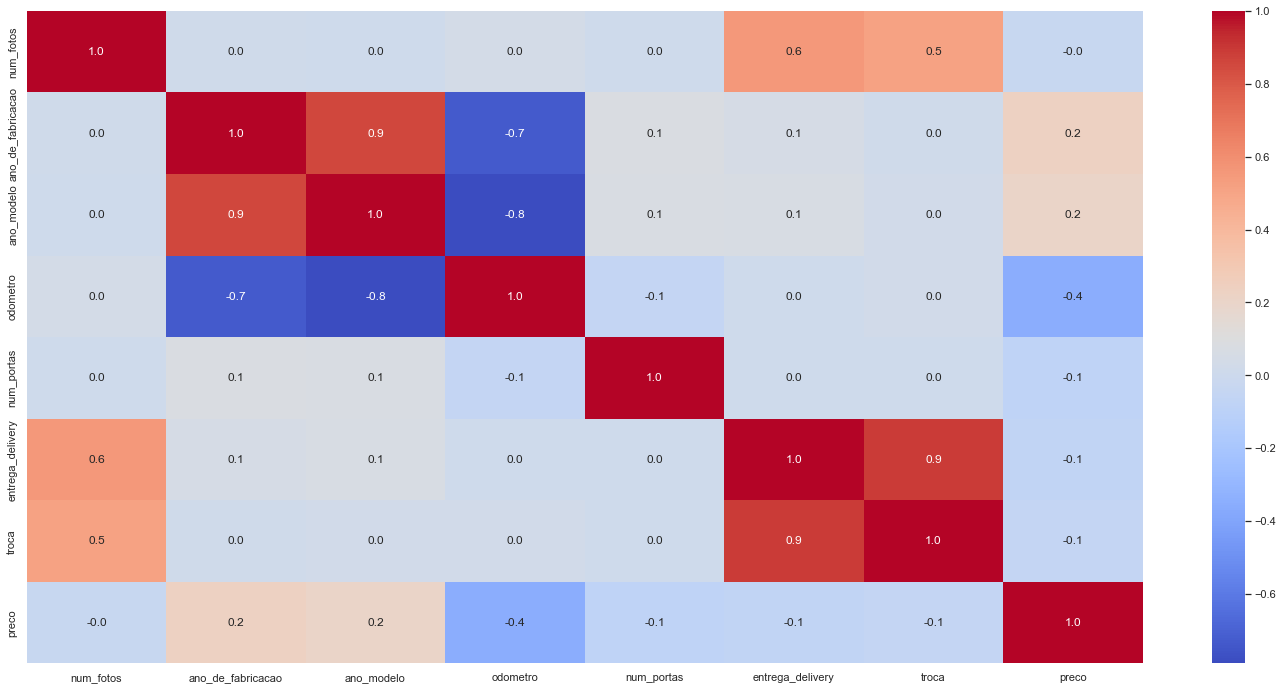

In [ ]:
plot = sns.heatmap(correlation, annot = True, fmt=".1f", cmap='coolwarm')
plot

# Tratando variaveis

In [ ]:
df_treino['attr_veiculo_aceita_troca'] = df_treino['attr_veiculo_aceita_troca'].apply(lambda x: 1 if (x == 'Aceita troca') else 0)
df_treino['attr_veiculo_único_dono'] = df_treino['attr_veiculo_único_dono'].apply(lambda x: 1 if (x == 'Único dono') else 0)
df_treino['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df_treino['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].apply(lambda x: 1 if (x == 'Todas as revisões feitas pela concessionária') else 0)
df_treino['attr_veiculo_ipva_pago'] = df_treino['attr_veiculo_ipva_pago'].apply(lambda x: 1 if (x == 'IPVA pago') else 0)
df_treino['attr_veiculo_licenciado'] = df_treino['attr_veiculo_licenciado'].apply(lambda x: 1 if (x == 'Licenciado') else 0)
df_treino['attr_veiculo_garantia_de_fábrica'] = df_treino['attr_veiculo_garantia_de_fábrica'].apply(lambda x: 1 if (x == 'Garantia de fábrica') else 0)
df_treino['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df_treino['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].apply(lambda x: 1 if (x == 'Todas as revisões feitas pela agenda do carro') else 0)

In [ ]:
df_treino['num_fotos'] = df_treino['num_fotos'].fillna(0)

In [ ]:
df_teste['attr_veiculo_aceita_troca'] = df_teste['attr_veiculo_aceita_troca'].apply(lambda x: 1 if (x == 'Aceita troca') else 0)
df_teste['attr_veiculo_único_dono'] = df_teste['attr_veiculo_único_dono'].apply(lambda x: 1 if (x == 'Único dono') else 0)
df_teste['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df_teste['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].apply(lambda x: 1 if (x == 'Todas as revisões feitas pela concessionária') else 0)
df_teste['attr_veiculo_ipva_pago'] = df_teste['attr_veiculo_ipva_pago'].apply(lambda x: 1 if (x == 'IPVA pago') else 0)
df_teste['attr_veiculo_licenciado'] = df_teste['attr_veiculo_licenciado'].apply(lambda x: 1 if (x == 'Licenciado') else 0)
df_teste['attr_veiculo_garantia_de_fábrica'] = df_teste['attr_veiculo_garantia_de_fábrica'].apply(lambda x: 1 if (x == 'Garantia de fábrica') else 0)
df_teste['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df_teste['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].apply(lambda x: 1 if (x == 'Todas as revisões feitas pela agenda do carro') else 0)

In [ ]:
df_teste['num_fotos'] = df_teste['num_fotos'].fillna(0)

In [ ]:
df_treino.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro', 'preco',
       'potencia', 'combustivel'],
      dtype='object')

# Treinando

In [ ]:
from xgboost import XGBRegressor
from category_encoders.count import CountEncoder

In [ ]:
y = df_treino['preco']
X = df_treino.drop(columns=['ID', 'preco'])

In [ ]:
cat_cols = df_treino.select_dtypes(include=['object']).columns[1:]

te = CountEncoder(cols=cat_cols, return_df=True)
X_pp = te.fit_transform(df_treino.drop(columns=['ID', 'preco']), df_treino['preco'])

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_pp, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
X_test_pp = te.transform(df_teste.drop(columns=['ID']))
X_test_pp = X_test_pp.fillna(0)

In [ ]:
pred = xgb.predict(X_test_pp)

In [ ]:
df_final = pd.concat([df_teste[['ID']], pd.Series(pred, name='preco')], axis=1)
df_final.head()

,ID,preco
0,24813264385557040124808779273028388499,68436.390625
1,295636316453795508942188530111300065666,109231.343750
2,101258309166227950735244624080888109884,88244.882812
3,28348734455782469411126661985772047409,67119.984375
4,193163160502972147671913739170248305797,136376.687500


In [ ]:
df_final.to_csv('submission.csv', index=False) #Arquivo de submissão pronto para ser enviado.